# Apr ??, 2022 ()

**Motivation**:explore node sizes Ca <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
mice = Mice((128, 3))
mice.setup_func_data('rest')

In [3]:
regions = [
    mice.parcel.encode(e) for e in
    mice.node_lookup['ca2'].values()
]
regions = np.array(sorted(regions))
len(regions)

154

In [4]:
from register.register import Register

reg = Register(mice)
reg.set_mode('ca2')

In [6]:
dlist = []
for sub, ses in itertools.product(mice.cfg.sub_ids, mice.cfg.ses_ids):
    key = mice.get_key(sub, ses)
    masks = reg.load_obj_masks(key, mask_names='cols')
    x = masks['cols'].numpy()
    region_sizes = collections.Counter(x[x.nonzero()])
    region_sizes = {
        r: region_sizes.get(r, 0)
        for r in regions
    }
    dlist.append({
        'key': [key] * len(regions),
        'region': region_sizes.keys(),
        'size': region_sizes.values(),
    })
df = pd.DataFrame(merge_dicts(dlist))

<AxesSubplot:xlabel='size', ylabel='Count'>

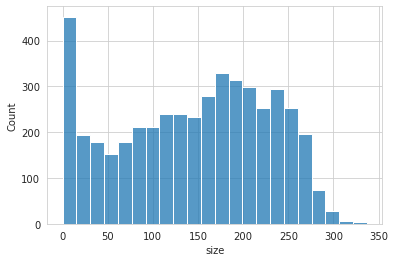

In [8]:
sns.histplot(data=df, x='size')

In [23]:
small2big = df.groupby(['region']).mean().sort_values('size').reset_index()['region'].values
small2big

array([394,  10, 502,  13, 479,  17, 401, 509, 397, 420,  95,  15,  36,
       125, 399, 118, 123, 505,  12, 507, 405,  35,  21, 396, 121, 412,
        28, 419,  82, 487,  48, 466, 506, 103, 500, 116, 122, 403,  19,
       432, 497,  59, 110, 113,  58,  49,  22, 494, 503, 119, 406,  71,
       117, 501, 442, 433, 455,  26, 410, 443, 411,  27, 404,  20,  92,
        70,  93, 108, 476, 102, 492,  34,  79, 485, 115, 477, 486,  39,
       418, 499, 423,  42,  81, 495, 454,  68, 101,  37, 413,  57, 463,
       111,  29, 426, 109, 421, 441, 465, 417, 452, 493,  90,  67, 469,
        46, 482,  55,  78,  33,  98,  85, 430, 104, 474, 434, 105, 488,
       439, 462,  41, 429,  50, 451,  45, 472, 489, 425,  88,  96,  76,
       480, 460,  54,  61,  86,  65,  97, 438, 445, 470, 459,  94, 449,
       478,  53, 481, 468,  75, 448, 458, 437,  84,  64,  74])

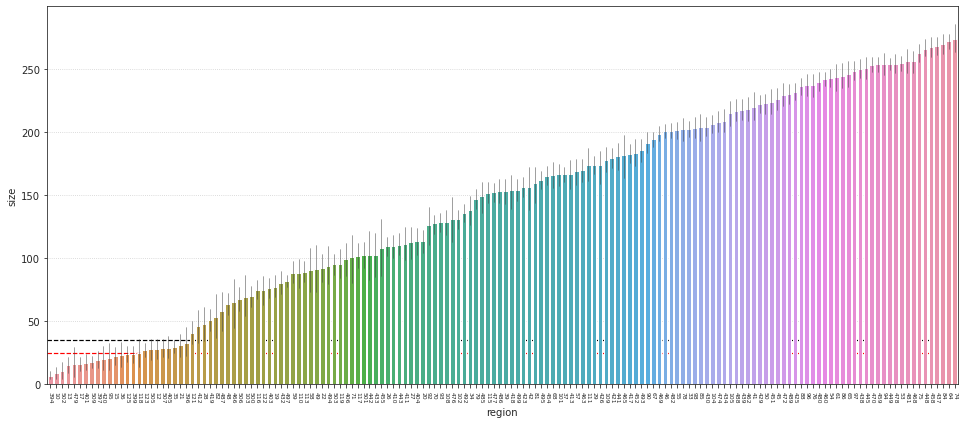

In [55]:
fig, ax = create_figure(figsize=(13.5, 6))
ax.axhline(35, color='k', lw=1.2, ls='--', zorder=0)
ax.axhline(25, color='r', lw=1.2, ls='--', zorder=0)
sns.barplot(
    data=df,
    x='region',
    y='size',
    order=small2big,
    hue_order=small2big,
    errwidth=0.5,
    ax=ax,
)
ax.tick_params(axis='x', rotation=-90, labelsize=6)
ax.grid(axis='y')

In [56]:
total_remove = []
mask_bad = {}
for sub, ses in itertools.product(mice.cfg.sub_ids, mice.cfg.ses_ids):
    key = mice.get_key(sub, ses)
    masks = reg.load_obj_masks(key, mask_names='cols')
    x = masks['cols'].numpy()
    region_sizes = collections.Counter(x[x.nonzero()])
    bad_regions = [r for r, s in region_sizes.items() if s < 25]
    mask_bad[key] = np.isin(x, bad_regions)
    total_remove.append(len(bad_regions))

<AxesSubplot:ylabel='Count'>

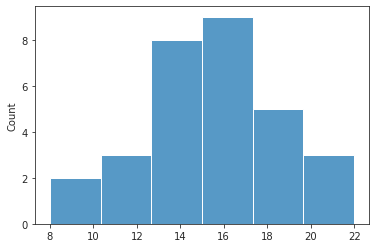

In [57]:
sns.histplot(total_remove)

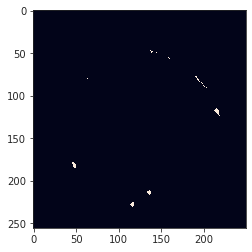

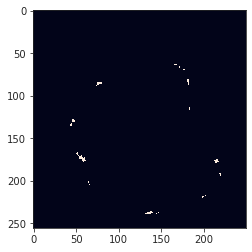

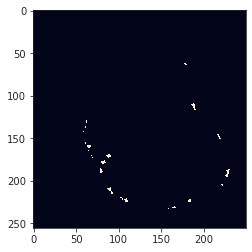

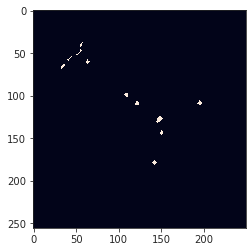

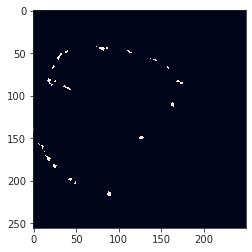

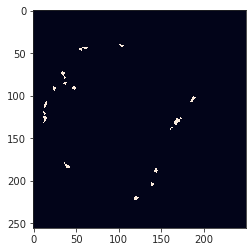

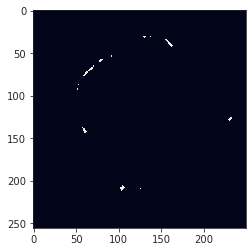

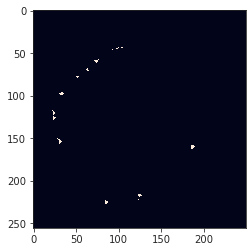

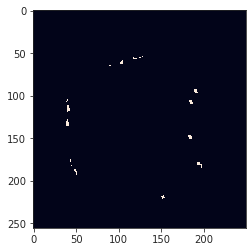

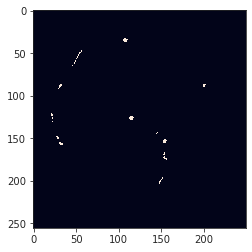

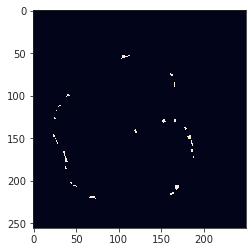

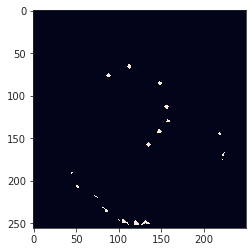

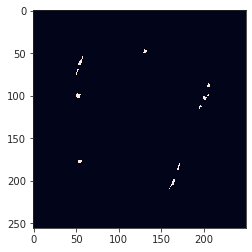

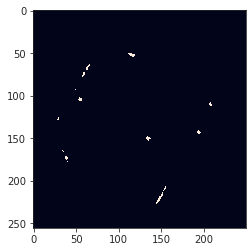

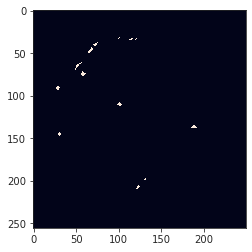

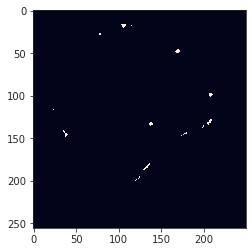

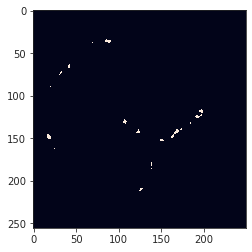

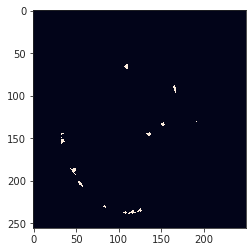

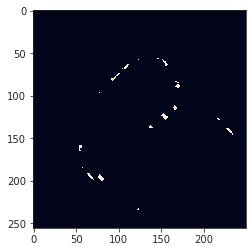

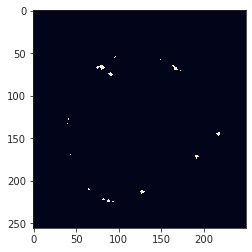

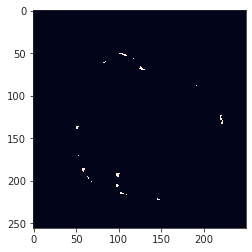

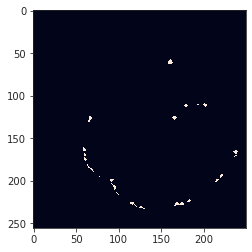

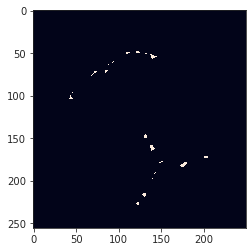

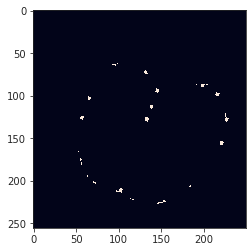

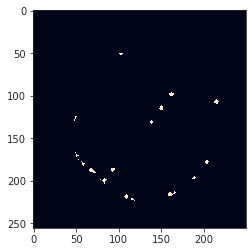

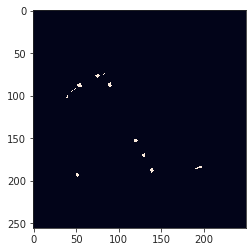

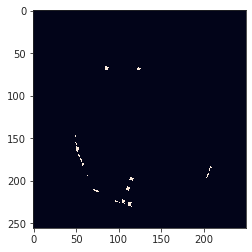

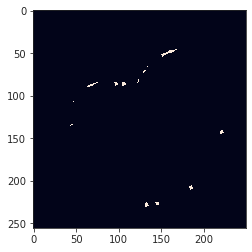

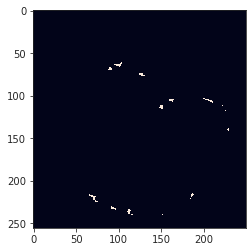

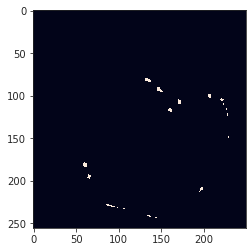

In [69]:
masks_final = {}
for sub, ses in itertools.product(mice.cfg.sub_ids, mice.cfg.ses_ids):
    key = mice.get_key(sub, ses)
    masks = reg.load_obj_masks(key, mask_names='cols')
    x = masks['cols'].numpy().astype(float)
    region_sizes = collections.Counter(x[x.nonzero()])
    sz_thres = np.quantile(list(region_sizes.values()), 0.1)
    bad_regions = [r for r, s in region_sizes.items() if s < sz_thres]
    good_regions = [r for r, s in region_sizes.items() if s >= sz_thres]
    x[np.isin(x, good_regions)] = 1
    x[np.isin(x, bad_regions)] = -1
    masks_final[key] = x

In [70]:
np.unique(v)

array([         0,          1, 4294967295], dtype=uint32)

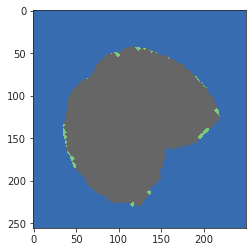

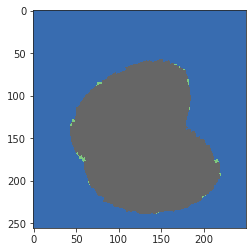

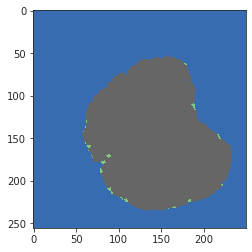

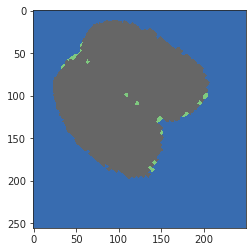

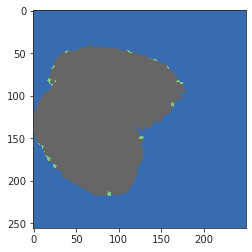

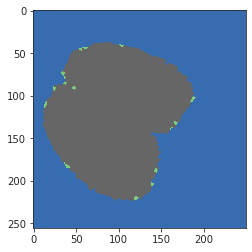

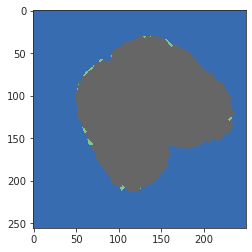

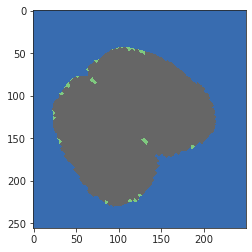

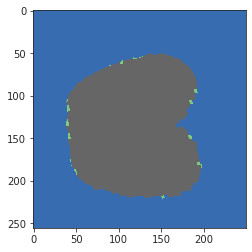

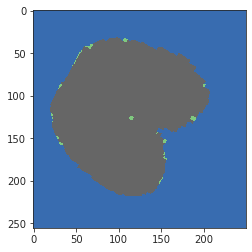

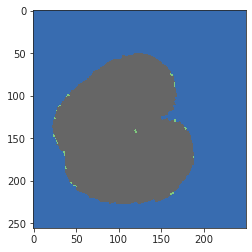

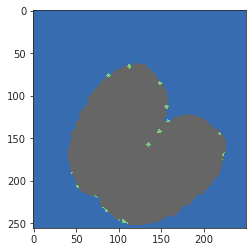

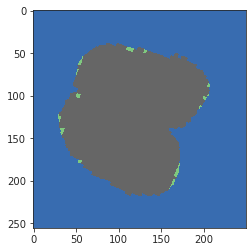

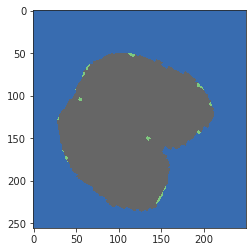

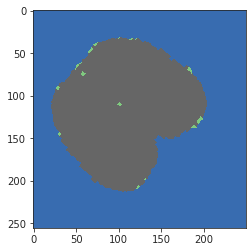

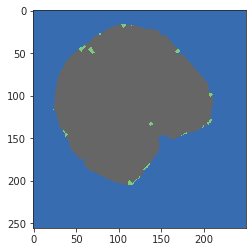

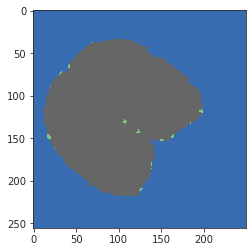

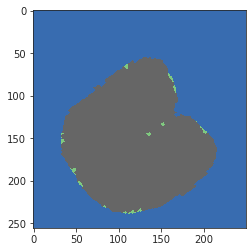

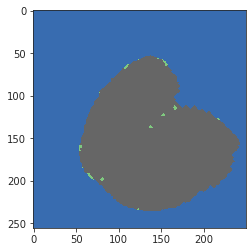

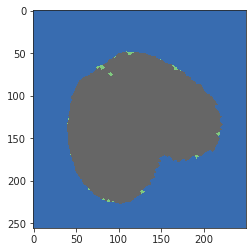

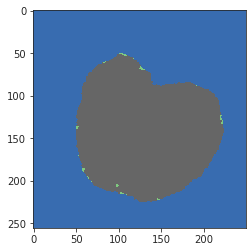

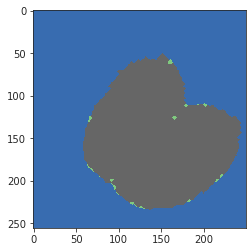

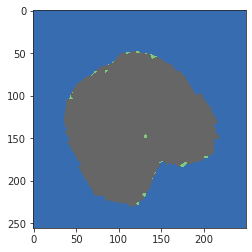

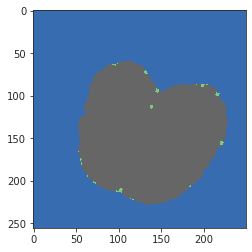

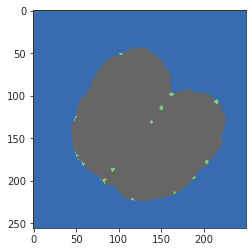

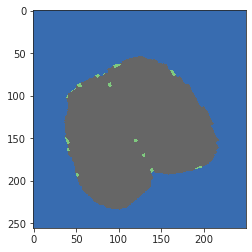

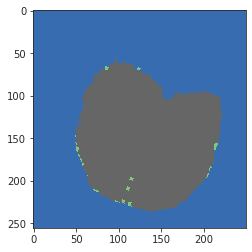

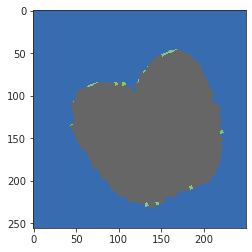

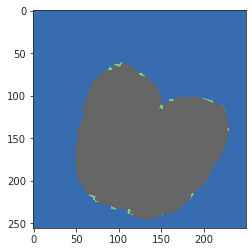

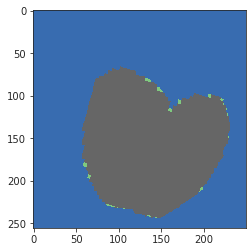

In [72]:
for k, v in masks_final.items():
    plt.imshow(v, cmap='Accent')
    plt.show()

In [63]:
np.quantile(xx, 0.1)

25.6

## TODO

1) Revisit "get accepted regions" for ca
2) Should I remove bottom 10 % after doing the thing I was doing before?
3) Should I remove bottom 10 % first, then do the thing I was doing before?
4) This has to be decided before node_lookup is save, because one node might be consistently in the bottom 10% and cause other problems
5) So, this decision will affect reg.get_accepted_regions() for Ca